# GS-Diffusion Refinement Notebook

This notebook is used to train and evaluate a diffusion-based refinement model for novel view synthesis in autonomous driving scenes. The model learns to enhance artifact-prone outputs (e.g., from DrivingForward or other 3DGS models) and produce higher-quality, photorealistic views.


In [3]:
from dataloaders import get_dataloaders
import matplotlib.pyplot as plt
from train import train_refiner
import torch
from train_diffusion import train_diffusion_refiner
from eval import evaluate_model, show_comparison

%load_ext autoreload
%autoreload 2
print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Dataloading and Preprocessing

In [2]:
train_loader, val_loader = get_dataloaders("data", batch_size=4, num_workers=8)

### Visualize data

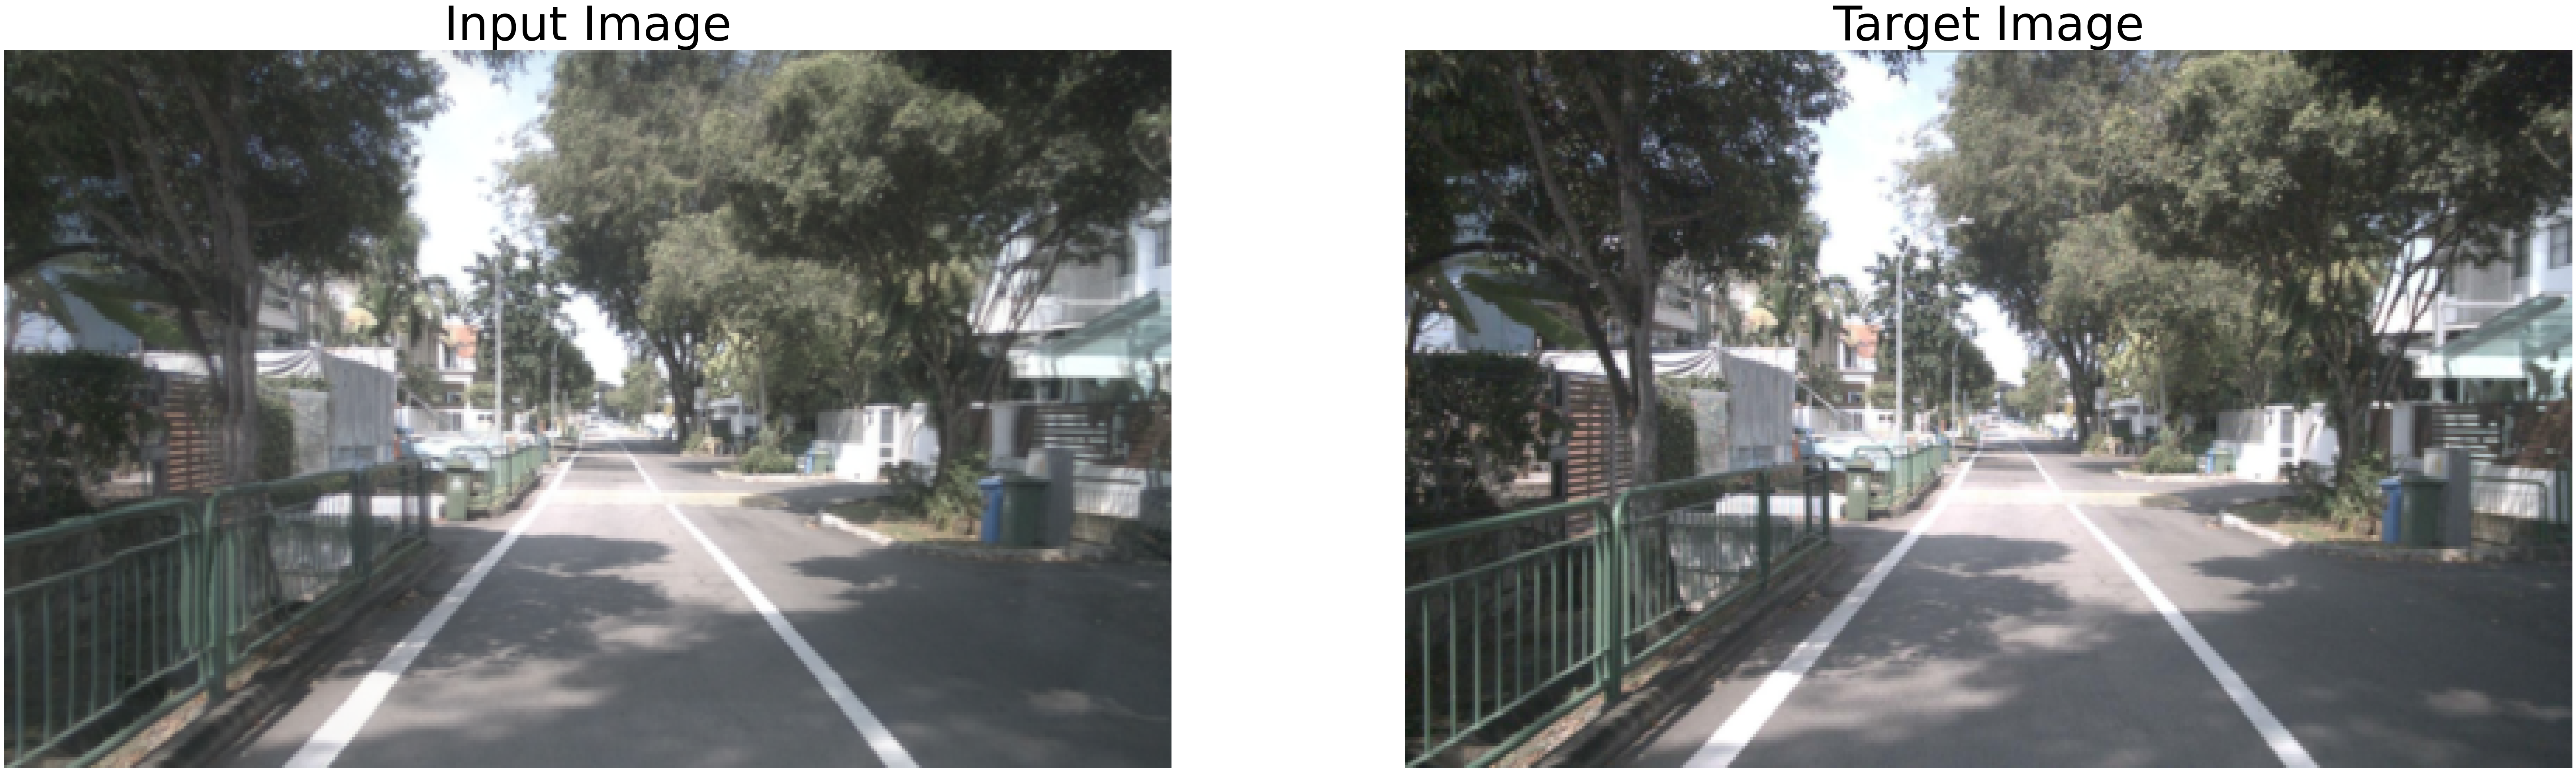

Batch number: 35, Batch size: 1
Sample index: 0
Input image shape: torch.Size([1, 3, 256, 416])
Target image shape: torch.Size([1, 3, 256, 416])
Token ID: 706c2bab659641a78137a6f9a34e2950


In [6]:
# ---------------------------------------------------------- #
# Select which batch and sample within that batch
batch_num = 35  # Select batch index (0-based)
sample_idx = 0  # Select sample within the batch (0-based)
# ---------------------------------------------------------- #
# Iterate through DataLoader to get the desired batch
for i, (x_batch, y_batch, token_ids) in enumerate(val_loader):
    if i == batch_num:
        break
else:
    raise ValueError(f"Batch {batch_num} does not exist in DataLoader.")

# Safety check
if sample_idx >= x_batch.shape[0]:
    raise ValueError(f"sample_idx {sample_idx} is out of range for batch size {x_batch.shape[0]}.")

input_height, input_width = x_batch.shape[2], x_batch.shape[3]
scale = 0.2

# Prepare images for display
input_img = x_batch[sample_idx].permute(1, 2, 0).cpu().numpy()
target_img = y_batch[sample_idx].permute(1, 2, 0).cpu().numpy()

# Normalize if necessary
if input_img.max() > 1.0:
    input_img = input_img / 255.0
if target_img.max() > 1.0:
    target_img = target_img / 255.0

input_img = input_img.clip(0, 1)
target_img = target_img.clip(0, 1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(input_width * scale, input_height * scale))
axes[0].imshow(input_img)
axes[0].set_title("Input Image", fontsize=86)
axes[0].axis("off")
axes[1].imshow(target_img)
axes[1].set_title("Target Image", fontsize=86)
axes[1].axis("off")
plt.show()

print(f"Batch number: {batch_num}, Batch size: {x_batch.shape[0]}")
print(f"Sample index: {sample_idx}")
print(f"Input image shape: {x_batch.shape}")
print(f"Target image shape: {y_batch.shape}")
print(f"Token ID: {token_ids[sample_idx]}")


# Trainin the model

In [ ]:
train_diffusion_refiner(
    train_loader,
    val_loader,
    epochs=5,          
    save_path="refiner_diffusion_unet.pth",
    device="cuda" if torch.cuda.is_available() else "cpu",
    lr=1e-4,
)

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Epoch 1/5 [Train]:  62%|██████▏   | 181/294 [20:46<12:29,  6.63s/it]

In [5]:
evaluate_model(
        dataloader=val_loader,
        weights_path="refiner_diffusion_unet_2.0.pth",
        device="cuda" if torch.cuda.is_available() else "cpu",
        save_dir="eval_outputs",
    )

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Evaluating: 100%|██████████| 196/196 [00:48<00:00,  4.03it/s]


✅ Final Evaluation Metrics:
   PSNR: 31.049
   SSIM: 0.896
   LPIPS: 0.032


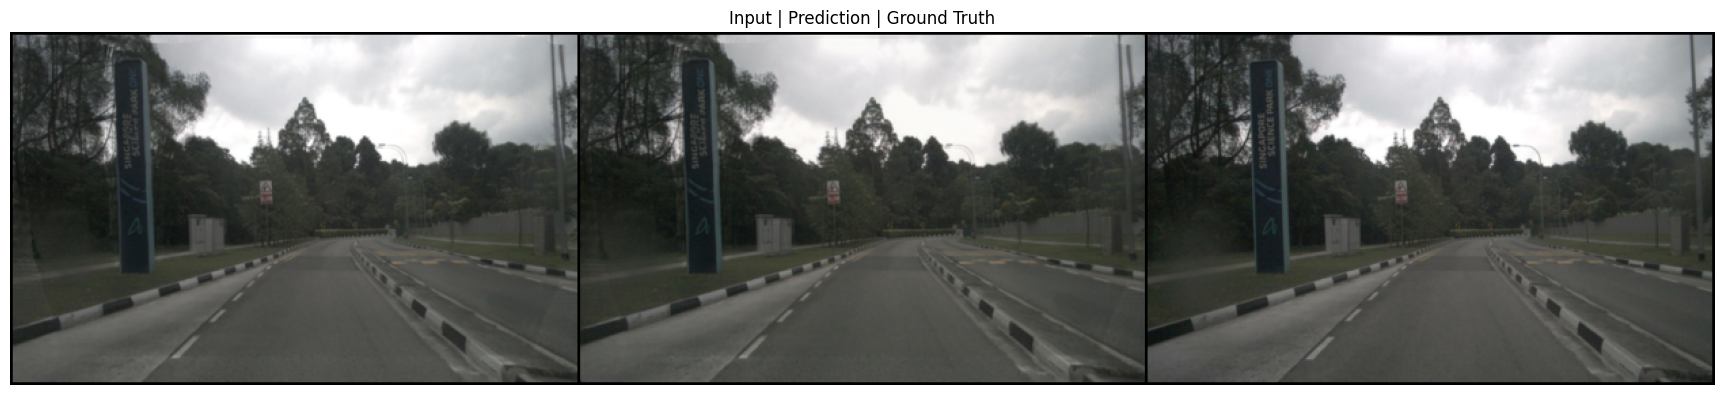

Input shape: torch.Size([3, 256, 416])
Prediction shape: torch.Size([3, 256, 416])
Ground Truth shape: torch.Size([3, 256, 416])


In [6]:
show_comparison('eval_outputs/9a466a62185f49929e4d66489d4be8e7')

In [7]:
train_loader, val_loader = get_dataloaders("data_sf", batch_size=4, num_workers=8)

In [8]:
evaluate_model(
        dataloader=val_loader,
        weights_path="refiner_diffusion_unet_2.0.pth",
        device="cuda" if torch.cuda.is_available() else "cpu",
        save_dir="eval_outputs",
    )

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Evaluating: 100%|██████████| 196/196 [00:47<00:00,  4.17it/s]


✅ Final Evaluation Metrics:
   PSNR: 22.109
   SSIM: 0.633
   LPIPS: 0.086


In [ ]:
show_comparison('eval_outputs/9a466a62185f49929e4d66489d4be8e7')